In [1]:
#import datajoint as dj
#from dj_ratacad import flashcount
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
import pickle
import seaborn as sns
sns.set(font_scale=1.2)
import mne

import pandas as pd
data = pd.read_pickle('SquirtleStage4.pkl')
#data=(flashcount.FlashCountTrial() & 'name = "Squirtle"' & 'outcome != "Omission"').fetch(format="frame")
data = data.reset_index(level=['trial_datetime', 'stage'])

#from dj_ratacad import flashes
#data=(flashes.FlashesTrial() & 'name = "1062"' & 'outcome != "Omission"').fetch(format="frame")
#data = data.reset_index(level=['trial_datetime', 'stage'])


data['Date'] = pd.to_datetime(data['trial_datetime']).dt.date
data['Hour'] = pd.to_datetime(data['trial_datetime']).dt.hour
def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = str(time_str).split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

data['Date'] = pd.to_datetime(data['trial_datetime'],utc=True).dt.date
data['Hour'] = pd.to_datetime(data['trial_datetime'],utc=True).dt.hour

data['Time'] = pd.to_datetime(data['trial_datetime'],utc=True).dt.time
data['Datetime'] = pd.to_datetime(data['trial_datetime'],utc=True)
data['S'] = data['Time'].apply(get_sec)



In [2]:
dt = data.loc[data['isprobe']==1]

In [3]:
dt

trial_datetime  stage choice  \
name     session_datetime    trial task                                      
Squirtle 2022-06-29 15:22:10 43    count 2022-06-29 18:52:56      4   left   
                             61    count 2022-06-29 19:51:13      4  right   
                             67    count 2022-06-29 23:24:26      4  right   
                             75    count 2022-06-29 23:26:29      4   left   
                             76    count 2022-06-29 23:26:37      4   left   
...                                                      ...    ...    ...   
         2022-07-14 12:39:51 25    count 2022-07-14 19:03:27      4  right   
                             34    count 2022-07-14 19:05:30      4   left   
                             48    count 2022-07-14 19:07:31      4  right   
                             94    count 2022-07-14 22:23:49      4  right   
                             114   count 2022-07-14 22:27:29      4  right   

                                          outcome      rt  init_time  \
name     session_datetime    trial task                                
Squirtle 2022-06-29 15:22:10 43    count    error  2.3958     8.1809   
                             61    count    error  2.4388   765.0720   
                             67    count  correct  1.4888    28.0192   
                             75    count  correct  2.4743     3.0875   
                             76    count  correct  2.0640     2.4367   
...                                           ...     ...        ...   
         2022-07-14 12:39:51 25    count  correct  1.6602     0.2724   
                             34    count  correct  1.9984     2.8950   
                             48    count  correct  2.2227    12.2271   
                             94    count  correct  1.7143     3.4683   
                             114   count  correct  2.0191    24.8416   

                                         correct_side  lambda_left  \
name     session_datetime    trial task                              
Squirtle 2022-06-29 15:22:10 43    count        right     0.083959   
                             61    count         left     0.981820   
                             67    count        right     0.006359   
                             75    count         left     0.994249   
                             76    count         left     0.942858   
...                                               ...          ...   
         2022-07-14 12:39:51 25    count        right     0.053551   
                             34    count         left     0.967594   
                             48    count        right     0.039752   
                             94    count        right     0.081653   
                             114   count        right     0.071901   

                                          lambda_right  flash_bins  ... probe  \
name     session_datetime    trial task                             ...         
Squirtle 2022-06-29 15:22:10 43    count      0.906189           0  ...     1   
                             61    count      0.074082           0  ...     1   
                             67    count      0.920270           0  ...     1   
                             75    count      0.050647           0  ...     1   
                             76    count      0.060178           0  ...     1   
...                                                ...         ...  ...   ...   
         2022-07-14 12:39:51 25    count      0.928961           0  ...     1   
                             34    count      0.020935           0  ...     1   
                             48    count      0.911185           0  ...     1   
                             94    count      0.977747           0  ...     1   
                             114   count      0.920233           0  ...     1   

                                         freerw  isprobe  reversal heavy_tail  \
name     session_datetime    trial task         

In [87]:
dt = data.loc[(data['trial_datetime'] >= pd.Timestamp(2022,6,1,23,59,4))]
dt = dt.iloc[:192]
print(dt)
dt['trial_datetime'].iloc[-1]

                                              trial_datetime  stage  \
name     session_datetime    trial task                               
Squirtle 2022-06-01 16:11:04 32    count 2022-06-01 23:59:04      4   
                             33    count 2022-06-01 23:59:10      4   
                             34    count 2022-06-01 23:59:21      4   
                             35    count 2022-06-01 23:59:26      4   
                             36    count 2022-06-02 00:22:59      4   
...                                                      ...    ...   
         2022-06-02 22:21:50 86    count 2022-06-03 02:42:37      4   
                             87    count 2022-06-03 02:42:44      4   
                             88    count 2022-06-03 02:42:50      4   
                             89    count 2022-06-03 02:43:00      4   
                             90    count 2022-06-03 02:46:30      4   

                                              choice  outcome      rt  \
nam

Timestamp('2022-06-03 02:46:30')

In [88]:
events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.01,initial_event=True,consecutive=True)
ChoiceEvent=events[events[:,2]==4] 
event_dict = {'e':0,'g':1}
print(ChoiceEvent.shape)
choiceLabel = np.array(dt.loc[:,"reward"])
ChoiceEvent[:len(choiceLabel),2] = choiceLabel
center_epochs = mne.Epochs(ed, ChoiceEvent,event_id=event_dict, tmin=-2, tmax=1, preload=True)

epochs_train = center_epochs.copy()
labels = center_epochs.events[:, -1] 
epochs_data_train = epochs_train.get_data()


1154 events found
Event IDs: [1 2 3 4]
(192, 3)
Not setting metadata
192 matching events found
Setting baseline interval to [-2.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 192 events and 601 original time points ...
0 bad epochs dropped


In [89]:
labels

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0])

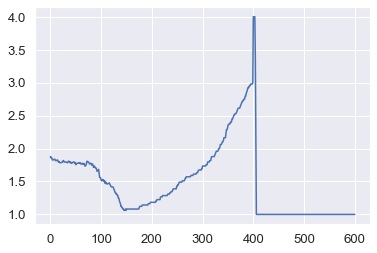

In [94]:
idx1 = np.where(labels==1)
plt.figure()
plt.plot(np.mean(epochs_data_train[idx1[0],4,:],axis=0))

In [93]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import (SlidingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)


scores = []
epochs_data = center_epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.3, random_state=42)
cv_split = cv.split(epochs_data_train)
clf = make_pipeline(
    Vectorizer(),
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

scores = cross_val_score(clf,epochs_data_train[:,4:5,:], labels, cv=cv, n_jobs=None)
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Classification accuracy: 1.000000 / Chance level: 0.510417


In [ ]:
month=6
date=2
e = mne.io.read_raw('/Volumes/Research/eng_research_scottlab/RATACAD_DATA/rawEEG/2022-'+ str(month).zfill(2) + '-'+ str(date).zfill(2)+'_raw.fif.gz',on_split_missing ='ignore')
ed = e.copy().resample(sfreq=200)
del e
    #getting Choice Event aligned


In [ ]:
month = 6
for date in range(2,3): 
    print (str(month)+ '/' + str(date))
    dt = data.loc[(data['trial_datetime'] >= pd.Timestamp(2022,month,date,23,0)) & (data['trial_datetime'] <= pd.Timestamp(2022,month,date+1,22,52))]

    #e = mne.io.read_raw('/Volumes/Research/eng_research_scottlab/RATACAD_DATA/rawEEG/2022-06-08_raw.fif.gz',on_split_missing ='ignore')
    e = mne.io.read_raw('/Volumes/Research/eng_research_scottlab/RATACAD_DATA/rawEEG/2022-'+ str(month).zfill(2) + '-'+ str(date).zfill(2)+'_raw.fif.gz',on_split_missing ='ignore')
    ed = e.copy().resample(sfreq=200)
    del e
    #getting Choice Event aligned
    events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.001,initial_event=True,consecutive=True)
    choiceLabel = np.array(dt.loc[:,"choice"])
    ChoiceEvent=events[events[:,2]==4] #choice
    if len(ChoiceEvent[:,2]) != len(choiceLabel):
        print("skip choice cant be aligned")
        pass
    else:
        events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.01,initial_event=True,consecutive=True)
        event_simple = mne.pick_events(events, exclude=[1,2])
        print(events)
        savedEvent = []
        #align to start of Trial!
        for i in range(event_simple.shape[0]):
            if event_simple[i,2] == 3:
                if (i+1) < event_simple.shape[0]:
                    if event_simple[i+1,2] == 4:
                        savedEvent.append(event_simple[i,:])
                    else:
                        pass

        centerEvent = np.array(savedEvent)
        choiceLabel = np.array(dt.loc[:,"choice"])
        rewardLabel = np.array(dt.loc[:,"reward"])
        if len(centerEvent[:,2]) == len(choiceLabel):
            for i in range(len(choiceLabel)):
                if (choiceLabel[i] == "left") and (rewardLabel[i] == 0):
                    choiceLabel[i] = 0 #left wrong
                elif (choiceLabel[i] == "left") and (rewardLabel[i] == 1):
                    choiceLabel[i] = 1 #Left correct
                elif (choiceLabel[i] == "right") and (rewardLabel[i] == 0):
                    choiceLabel[i] = 0 #right wrong
                elif (choiceLabel[i] == "right") and (rewardLabel[i] == 1):
                    choiceLabel[i] = 1 #right correct
                elif choiceLabel[i] == "earlyleft":
                    choiceLabel[i] = -1 #early left
                else:
                    choiceLabel[i] = -1 #early right
            centerEvent[:,2] = choiceLabel
        else:
            print("skip center cant be aligned")
            pass

In [ ]:
events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.01,initial_event=True,consecutive=True)
ChoiceEvent=events[events[:,2]==4] #choice
dt = data.loc[(data['trial_datetime'] >= pd.Timestamp(2022,5,31,23,59,4)) & (data['trial_datetime'] <= pd.Timestamp(2022,6,1,23,59,4))]
choiceLabel = np.array(dt.loc[:,"choice"])

print(len(ChoiceEvent[:,2]))
print(len(choiceLabel))
dt

In [ ]:
#events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.001,initial_event=True,consecutive=True)
choiceLabel = np.array(dt.loc[:,"choice"])
rewardLabel = np.array(dt.loc[:,"outcome"])
for i in range(len(choiceLabel)):
    if (choiceLabel[i] == "left") and (rewardLabel[i] == "error"):
        choiceLabel[i] = 0 #left wrong
    elif (choiceLabel[i] == "left") and (rewardLabel[i] == "correct"):
        choiceLabel[i] = 1 #Left correct
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == "error"):
        choiceLabel[i] = 0 #right wrong
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == "correct"):
        choiceLabel[i] = 1 #right correct
    elif choiceLabel[i] == "earlyleft":
        choiceLabel[i] = -1 #early left
    else:
        choiceLabel[i] = -1 #early right
        
ChoiceEvent=events[events[:,2]==4] #choice
ChoiceEvent[:,2] = choiceLabel
print(len(choiceLabel))
event_dict = {'left':0,
             'right':1,
             'early':-1}
#fig = mne.viz.plot_events(ChoiceEvent, event_id=event_dict, sfreq=ed.info['sfreq'],
#                          first_samp=ed.first_samp)

choice_epochs = mne.Epochs(ed, ChoiceEvent,event_id=event_dict, tmin=-2, tmax=1, preload=True)

epochs_train = choice_epochs.copy()
labels = choice_epochs.events[:, -1] 
print(labels.shape)
epochs_data_train = epochs_train.get_data()


In [ ]:
print(epochs_data_train.shape)

epochs_data_train = epochs_data_train[1:,:,:]
labels = labels[:-1]
print(labels.shape)
epochs_data_train.shape
idx1 = np.where(labels==0)
plt.figure()
plt.plot((epochs_data_train[idx1[0],4,:],axis=0))

In [ ]:
idx1 = np.where(labels==1)
plt.figure()
plt.plot(np.mean(epochs_data_train[idx1[0],4,:],axis=0))

In [ ]:
events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.01,initial_event=True,consecutive=True)

event_simple = mne.pick_events(events, exclude=[1,2])
print(events)
savedEvent = []
#align to start of Trial!
for i in range(event_simple.shape[0]):
    if event_simple[i,2] == 3:
        if (i+1) < event_simple.shape[0]:
            if event_simple[i+1,2] == 4:
                savedEvent.append(event_simple[i,:])
            else:
                pass
        
print(len(savedEvent))
centerEvent = np.array(savedEvent)
centerEvent.shape
choiceLabel = np.array(dt.loc[:,"choice"])
rewardLabel = np.array(dt.loc[:,"reward"])
for i in range(len(choiceLabel)):
    if (choiceLabel[i] == "left") and (rewardLabel[i] == 0):
        choiceLabel[i] = 0 #left wrong
    elif (choiceLabel[i] == "left") and (rewardLabel[i] == 1):
        choiceLabel[i] = 1 #Left correct
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == 0):
        choiceLabel[i] = 0 #right wrong
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == 1):
        choiceLabel[i] = 1 #right correct
    elif choiceLabel[i] == "earlyleft":
        choiceLabel[i] = -1 #early left
    else:
        choiceLabel[i] = -1 #early right
centerEvent[:,2] = choiceLabel

center_epochs = mne.Epochs(ed, centerEvent,event_id=event_dict, tmin=-1, tmax=3, preload=True)

epochs_train = center_epochs.copy()
labels = center_epochs.events[:, -1] 
print(labels.shape)
epochs_data_train = epochs_train.get_data()

In [ ]:
print(epochs_data_train.shape)
epochs_data_train = epochs_data_train[1:,:,:]
labels = labels[:-1]
print(labels.shape)
epochs_data_train.shape

In [ ]:
idx1 = np.where(labels==0)
plt.figure()
plt.plot(np.mean(epochs_data_train[idx1[0],4,:],axis=0))

In [ ]:
idx1 = np.where(labels==0)
idx2 = np.where(labels==1)
e = 1000000*epochs_data_train[idx1[0],0,:]
d = 1000000*epochs_data_train[idx2[0],0,:]
e = np.mean(e,axis=0)
d = np.mean(d,axis=0)

print(e.shape)
timesampled = e.shape[0]
timestart = 0.1+0.125

timestop = 1.375-0.125

e = e[int(timestart*timesampled):int(timestop*timesampled),]
d = d[int(timestart*timesampled):int(timestop*timesampled),]
print(e.shape)
from statsmodels.tsa.seasonal import seasonal_decompose
series5 = np.transpose(e)
result5 = seasonal_decompose(series5, model='additive',period=round(e.shape[0]/10))

series4 = np.transpose(d)
result4 = seasonal_decompose(series4, model='additive',period=round(d.shape[0]/10))

fig, ax = plt.subplots(4, 1, figsize=(10, 5),sharex=True)
ax[0].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.observed,label='w')
ax[0].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.observed,label='r')
ax[0].legend()
#ax[0].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[0].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[1].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.trend,label='w')
ax[1].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.trend,label='r')
#ax[1].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[1].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[2].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.seasonal,label='w')
ax[2].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.seasonal,label='r')
#ax[2].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[2].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')


ax[3].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.resid,label='w')
ax[3].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.resid,label='r')
#ax[3].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[3].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')
#ax[3].legend()

In [ ]:
from scipy.signal import find_peaks
x = result4.resid
plt.figure()
#peaks, properties = find_peaks(x, height=2)
plt.plot(x)
#plt.plot(peaks, x[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
#plt.show()
#plt.figure()
peaks, properties = find_peaks(x, prominence=2, width=1)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")

plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
           ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")


#peaks, properties = find_peaks(x, prominence=2, width=1)
p0 = properties["prominences"]
w0 = properties["widths"]
plt.figure()
plt.plot(p0,'bo-')
plt.xlabel("au")
plt.ylabel("prominence")
plt.figure()
plt.plot(w0,'ro-')
plt.xlabel("au")
plt.ylabel("width")
plt.legend()
plt.show()

In [ ]:
print(x.shape)
timesampled = x.shape[0]
am = []
for i in range(10):
    timestart = i*int(timesampled/10)
    timestop =  (i+1)*int(timesampled/10)
    #print(timestart)
    #print(timestop)
    peaks, properties = find_peaks(x[timestart:timestop], prominence=2, width=1)
    am.append(np.var(properties["prominences"]))
plt.plot(am)
plt.ylabel("ave prom")
plt.xlabel("time bin")